# Bayesian Price Optimization with PyMC3
### PyMC3, Killer Visualizations, and Probabilistic Decision Making

In this article, we’re going to explore price optimization from the Bayesian perspective. So what is price optimization?

It’s optimizing the price of a good or service given costs and revenue. Revenue is generally subject to the “demand curve,” which is simply a relation between price and units demanded by consumers. A price too low would attract anyone and everyone who’s in the market but wouldn’t bring in enough revenue to outweigh the costs. But the inverse is also true. If the price is too high, so few customers (if any) will be attracted; so costs could outweigh revenue all the same. Hence the task of optimization.

As we’ll see the costs could be any function of the units demanded. This could be purchase, storage, transportation or any basically any cost related to the units demanded. In this case, we’ll make a simple assumption for illustrative purposes, but the function could be changed to meet any arbitrary cost that needs to be accounted for.

### So why Bayesian?
The Frequentist approach uses confidence intervals. This means we’re X% confident that the true value of some parameter falls in a given interval. But what about our confidence within that interval? The Frequentist approach doesn’t help us much here. And to make matters worse, parameters are often correlated with one another.

The Bayesian approach, on the other hand, models the joint distribution over all parameters. Sure, we can make an X% credible intervals — but our analysis gives us the shape that the parameters’ joint distribution follows. When we want to simulate how revenue, cost, and profits respond to changes in price, confidence intervals just aren’t transparent enough for out purposes.

### Data Simulation
Let’s say we’re working a lemonade stand on a hot summer day and we’re selling quarts of lemonade. We’ve got a cooler, which we rented for a fixed fee of 50 dollars and it costs us 1.5 dollars in ice for each quart of lemonade — that’s ridiculous, I know. But it’s a cost constraint, which we’ll implement later for illustrative purpose so that you can swap it out for a cost function of your own.

First, we need a demand curve; we’ll simulate our own for simplicity. There are multiple approaches to demand curve modeling. One that tends to work really well incorporates exponential decay. As the price approaches zero, the predicted demand would be infinitely high, whereas if the price were arbitrarily (infinitely) high, the demand would asymptotically approach zero.

How did we get this curve? Well, I’ve just spilled the beans, it’s simulated! But let’s say that you’ve offered quarts of lemonade at various prices and you’ve observed the following pattern. In actuality, using discounts is a science of its own. You get clarity on the demand curve as well as estimating efficacy of marketing channels. We won’t get into discounts and pricing experiments here, hence the simulation.

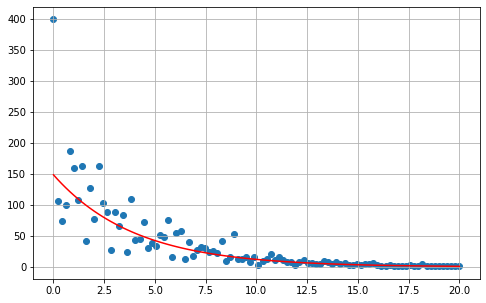

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

sd = 0.5
m,b = -0.25, 5
X = np.linspace(0,20,100)
Y = np.exp(np.random.normal(loc=m*X+b, scale=sd))

plt.figure(figsize=(8,5))
plt.grid("darkgrid")
plt.scatter(X,Y)
Y_hat = np.exp(m*X+b)
plt.plot(X,Y_hat, color='r')
plt.show()

### Bayesian Linear Model
We’re essentially just uncovering the very parameters that we set. A linear relationship exists between price and log units demanded (since demand exhibits exponential decay.)

Why a Bayesian model? Rather than inferring confidence intervals around the individual parameters, intercept and slope, we can infer the joint distribution over them. This is excellent! It allows us to infer distributions over things like revenue, costs, and profits.

A Frequentist approach would use a single slope and intercept, yielding point estimates on revenue, cost, or profits. This would leave us unable to articulate our certainty on optimal decision making.

As you can see, PyMC3 syntax is super user friendly and easy to follow along. If you’re already familiar with Bayesian analysis, you’ll note the priors I’ve placed on m, b, and s, our slope, intercept, and noise term. These effectively regularize the search space. The slope and intercept could be positive or negative, so I’ve used normal priors. However, the noise (error) can never be negative, hence I’ve chosen the exponential distribution.

In [2]:
import pymc3 as pm
with pm.Model() as model:
  m = pm.Normal('m',mu=0, sd=2)
  b = pm.Normal('b',mu=0, sd=2)
  s = pm.Exponential('s',lam=1)
  y_hat = pm.math.dot(m, X) + b
  lik = pm.Normal('lik', mu=y_hat, observed=pm.math.log(Y), sigma=s)
  trace = pm.sample(chains=4)
    
save_trace = pm.save_trace(trace)

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable C:\Program
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [s, b, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 745 seconds.
The acceptance probability does not match the target. It is 0.8846739699006694, but should be close to 0.8. Try to increase the number of tuning steps.


### Posterior Predictive Plot
Let’s see the Bayesian approach in action with the posterior predictive distribution. One of the really useful features of Bayesian analysis is the ability to generate a posterior predictive distribution. This means we can visualize what our model thinks is (and what isn’t!) likely. We sample from the joint distribution over slopes and intercepts, infer predictions over units demanded given an array of prices, and plot. The plotted lines succinctly capture the variance around our price-demand relationship!

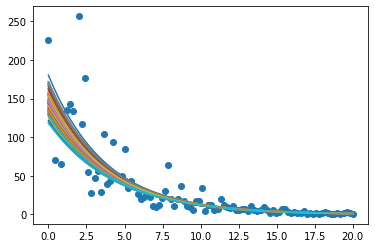

In [3]:
import random
def post_plot(trace_obj=trace,samples=100,size=len(X)):
  for itr in range(samples):
    idx = random.choice(range(size))
    m = trace_obj.get_values('m')[idx]
    b = trace_obj.get_values('b')[idx]
    Y_hat = np.exp(m*X + b)
    plt.plot(X,Y_hat)
  plt.scatter(X,Y)

post_plot()  

### Revenue and Profit
The last step(s) boil down to defining a cost function and inferring predictions over demand, revenue, cost, and profit, which we treat as random variables with distributions of their own.

Revenue is simple, it’s the price multiplied by the units demanded. And I’ve decided arbitrarily that the cost is $50 overhead plus $1.5/unit. However, this cost function could be swapped out for any function of the units demanded.

<AxesSubplot:>

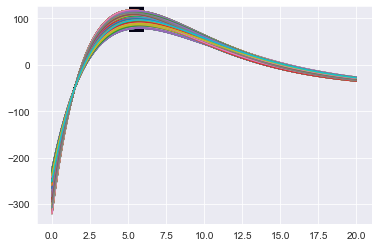

In [8]:
def rev_posterior(samples=100, size=len(X)):
  for s in range(samples):
    idx = random.choice(range(size))
    m = trace.get_values('m')[idx]
    b = trace.get_values('b')[idx]
    rev = X * np.exp(m*X +b)
    plt.plot(X, rev)
  return 

# rev_posterior()  
@np.vectorize
def cost(X):
  return 1.5*X + 50

def prof_posterior(samples=100, size=len(X)):
  prices = []
  profits = []
  for s in range(samples):
    idx = random.choice(range(size))
    m = trace.get_values('m')[idx]
    b = trace.get_values('b')[idx]
    demand = np.exp(m*X +b)
    rev = X * demand
    prof = rev - cost(demand)
    plt.plot(X, prof)
    
    best_price = X[np.argmax(prof)]
    best_prof = np.max(prof)
    prices.append(best_price)
    profits.append(best_prof)
  return prices,profits   

prices, profits = prof_posterior(samples=1000)

sns.kdeplot(x=prices, y=profits, cmap='inferno', fill=True, thresh=0)

Above, we can see that the price of `$5.7`/unit corresponds to the maximized profits. Another way visualization below captures this relationship in 2D. The hot center shows that `$5.7` price could bring in `$90–100` total profit given demand, revenue and costs.

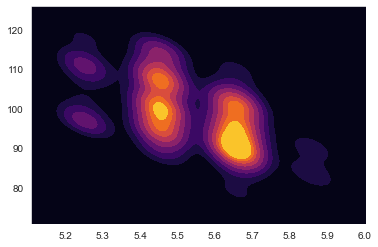

In [9]:
# set seaborn style
sns.set_style('darkgrid')
sns.kdeplot(x=prices, y=profits, cmap='inferno', fill=True, thresh=0)
plt.show()

This last graph shows the relationship between price and profit, which is the penultimate relationship of interest in price optimization. We now know that we can sell some good or service for about `$5.7`, generating `$90–100` in profit.

There you have it! I hope I’ve persuaded you to at least try the Bayesian approach. A little extra upfront work gives you a more robust framework to understand your decision space.